In [127]:
# import sys

# import gymnasium as gym
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic,DotProduct,ConstantKernel as C
from sklearn.model_selection import train_test_split

In [128]:
np.random.seed(0)

#Hole=[5,7,11,12]
T=80 # Time Horizon
# K=130
N=1000 #  Iteration number of outer loop 
M=40# iteration number for Q-learning

#Hole=[5,6,7,17,18,19]

# initial_gauss_set=[0,1,2,3,4,5,6,7,8,9]
# safe_s0=[0,1,2,3,4,5,9,10,11,12,13,14]


# 8*8 parameter
# nA=8
# nS = 64
# nrow = ncol = 8
# e_risk=1.5


# 12*12 parameter
nA=8
nS = 144
nrow = 12
ncol = 12

e_risk=1.25
safe_s0=[0,1,2,3,4,5]
initial_gauss_set=[0,1,2,3,4,5,12,13,14,15,16,17,24,25,26,27,28,29]
total_violation=0
# e_risk=0.75
# safe_s0=[0,1,2,3,4,5,12,13,14,15,16,17]
# initial_gauss_set=[0,1,2,3,4,5,12,13,14,15,16,17,24,25,26,27,28,29]

# e_risk=0.75
# safe_s0=[0,1,2,3,4,5,12,13,14,15,16,17,24,25,28,29]
# initial_gauss_set=[0,1,2,3,4,5,12,13,14,15,16,17,24,25,26,27,28,29]
# 16*16 parameter
# nA=8
# nS = 256
# nrow = 16
# ncol = 16
# e_risk=0.75

# safe_s0=[0,1,2,3,4,5,6,16,17,18,19,20,21,22,35,36,37,38]
# initial_gauss_set=[0,1,2,3,4,16,17,18,19,20,32,33,34,35,36]

c_Qlearning=20
# gamma=0.97
#n=10  sample number of transition kernel
 # data number for post##change every time

# V=50 #number of comparasion
# mt=30


"""""
V=50 #number of comparasion
mt=50
K=40
"""""
# 8*8 parameter
# cost_s=0
# cost_d=1
# cost_h=2


# 16*16 parameter
cost_s=0
cost_A=0.5
cost_B=1
cost_C=1.5
cost_D=2
# beta=0.7
# nu=0.5
# prior=np.ones(4)
sigma_noise=0
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
#action in {(+-1,+-2),(+-2,+-1)}
MAPS = {
    "4x4": ["SFFF", "FHFH", "FFFH", "HFFG"],
    "5x5": [
        "SFFFF",
        "HHHFF",
        "FFFFF",
        "FFHHH",
        "FFFFG",
    ],
    "8x8": [
        "SBFFFFDD",
        "DBBBFFBD",
        "DDDDBFBD",
        "DDDBFFBD",
        "DBBFBBBB",
        "DBFBDDDD",
        "BBFFBBBD",
        "DDBFFFFG",
    ],
    "12x12":[
        "SFFFFFFFFFFF",
        "AAAAAAAAAAFF",
        "BBCCBBBBBAFF",
        "BAAAAAAAAAFF",
        "AFFFFFFFFFFF",
        "FFFFFFFFFFFF",
        "FFAAAAAAAAAA",
        "FABBBBAABBBB",
        "FAAACCAAABCC",
        "FFAABBAAAABB",
        "FFFFAAFFFFAA",
        "FFFFFFFFFFFG",
    ],
    "16x16":[
        "SFFFFFFFFFFFFFFF",
        "AAAFFFFFFFFFFFFF",
        "BBBAFFFFFFAAAFFF",
        "CDCBAFFFFABBBAFF",
        "BBBAFFFFABBAAFFF",
        "AAAFFFFAABAAFFFF",
        "FFFFFAAABBAFFFFF",
        "FFFFABBBBAFFFFFF",
        "FFFABCDCBAAAAAAA",
        "FFFABBBBBAABBBBB",
        "FFFAAAAAAFABCCCC",
        "FFFFFFFFFFFABCDD",
        "AAFFFFFFFFFFABCD",
        "ABAFFFFAAFFFABCC",
        "FAFFFFABBAFFFABB",
        "FFFFFABBBBAFFFFG",
    ],
}
desc = MAPS["12x12"]
desc = np.asarray(desc, dtype="c")


In [129]:
def to_row_col(state):
    return int((state - state% ncol)/ ncol), state% ncol
        
def to_s(row, col):
    return row * ncol + col

def inc(row, col, a):
    if a == LEFT:
        col = max(col - 1, 0)
    elif a == DOWN:
        row = min(row + 1, nrow - 1)
    elif a == RIGHT:
        col = min(col + 1, ncol - 1)
    elif a == UP:
        row = max(row - 1, 0)
    return (row, col)


def inc_random(row, col, a):#a=(+-1,+-2)
    choice=np.zeros(2)
    if a[0]>=0:
        choice[0]=RIGHT
    else:
        choice[0]=LEFT
    if a[1]>=0:
        choice[1]=UP
    else:
        choice[1]=DOWN
    action=np.random.choice(choice,p=np.absolute(a)/3)
    return inc(row, col,action)

# def order_to_sa(n):
#     return [int((n - n% nA)/ nA), n% nA]
def action_to_number(a):
    if abs(abs(a[0])-1)<=1e-5:
        i=0
    else: 
        i=4
    if a[0]>=0 and a[1]>=0:
        j=0
    elif    a[0]>=0 and a[1]<0:
        j=1
    elif    a[0]<0 and a[1]>=0:
        j=2
    else:j=3
    return i+j

def number_to_action(n):
    i,j=int((n - n% 4)/ 4), n% 4
    if i==0 and j==0:
        h=np.array([1,2])
    elif i==0 and j==1:
        h=np.array([1,-2])
    elif i==0 and j==2:
        h=np.array([-1,2])
    elif i==0 and j==3:
        h=np.array([-1,-2])        
    elif i==1 and j==0:
        h=np.array([2,1])
    elif i==1 and j==1:
        h=np.array([2,-1])
    elif i==1 and j==2:
        h=np.array([-2,1])
    else:
        h=np.array([-2,-1])  
    return h 

def order_to_state(n):
    return [int((n - n%  nrow)/ nrow), n%  nrow]

# def sa_to_s(s,a):
#     row,col=to_row_col(s)
#     return int(to_s(inc(row,col,a)[0],inc(row,col,a)[1]))
def compare_set(A,B):
    l1=len(A)
    l2=len(B)
    if l1!=l2:
        return False   
    else: 
        for i in range(l1):
            if A[i]!=B[i]:
                return False
    return True

def sa_to_s_random(s,a):
    row,col=to_row_col(s)
    (new_row,new_col)=inc_random(row,col,number_to_action(a))
    return int(to_s(new_row,new_col))

def stateset_to_grid(S):
    grid=2*np.ones((nrow,ncol))
    for s in S:
        grid[to_row_col(s)[0],to_row_col(s)[1]]=0
    
    return grid

def plot_set(S,color='Blues'):
    plt.rcParams['font.sans-serif'] = ['SimHei']  
    plt.rcParams['axes.unicode_minus'] = False  
    plt.figure(figsize=(8, 8))
    plt.imshow(S,cmap=color) 
    plt.colorbar()
    plt.show()

def plot_state_set(S,color='Blues'):
    plot_set(stateset_to_grid(S),color)
    

def plot_route(dataset,color='Blues'):
    S=[]
    l=len(dataset)
    if l !=0:
        for i in range(l):
            S.append(dataset[i][0])
            if dataset[i][0]==nS-1:
                break
        if dataset[l-1][0]!=nS-1:     
            S.append(dataset[l-1][2])
    plot_state_set(S,color)

def distance_p2s(s,S):
    g=np.zeros(len(S))
    for i in range(len(S)):
        r1,c1=to_row_col(s)
        r2,c2=to_row_col(S[i])
        g[i]=np.sqrt((r1-r2)**2+(c1-c2)**2)
    return np.min(g)

def distance_p2p(s1,s2):
    r1,c1=to_row_col(s1)
    r2,c2=to_row_col(s2)
    np.sqrt((r1-r2)**2+(c1-c2)**2)
    return np.min(np.sqrt((r1-r2)**2+(c1-c2)**2)) 

def gauss_fit_initial(mu_input,cov_input,dataset):
    mu=np.copy(mu_input)
    cov=np.copy(cov_input)
    new_mu=np.zeros(nS)
    new_cov=np.zeros((nS,nS))
    for i in range(len(dataset)):
        s=dataset[i][0]
        row,col=to_row_col(s)
        y=dataset[i][3]
        new_mu=mu+cov[:,s]/(cov[s,s])*(y-mu[s])#+sigma_noise)
        new_mu[s]=y
        for j in range(nS):
            for k in range(nS):
                new_cov[j,k]=cov[j,k]-cov[j,s]*cov[k,s]/(cov[s,s])#+sigma_noise)
                    #print(str(i)+','+str(j)+','+str(k)+':'+str(new_cov[j,k]-cov[j,k]))
        new_cov[:,s]=0
        new_cov[s,:]=0
        mu=np.copy(new_mu)
        cov=np.copy(new_cov)

    return mu, cov

def gauss_fit(mu_input,cov_input,dataset,state_visit):
    mu=np.copy(mu_input)
    cov=np.copy(cov_input)
    new_mu=np.zeros(nS)
    new_cov=np.zeros((nS,nS))
    visit_set=np.copy(state_visit)
    for s in initial_gauss_set:
        visit_set[to_row_col(s)[0],to_row_col(s)[1]]=1
    for i in range(len(dataset)):
        s=dataset[i][0]
        row,col=to_row_col(s)
        if  visit_set[row,col]==0:
            visit_set[row,col]+=1
            y=dataset[i][3]
            new_mu=mu+cov[:,s]/(cov[s,s])*(y-mu[s])#+sigma_noise)
            new_mu[s]=y
            for j in range(nS):
                for k in range(nS):
                    new_cov[j,k]=cov[j,k]-cov[j,s]*cov[k,s]/(cov[s,s])#+sigma_noise)
                    #print(str(i)+','+str(j)+','+str(k)+':'+str(new_cov[j,k]-cov[j,k]))
                    #print(str(i)+','+str(j)+','+str(k)+':'+str(cov[j,s]*cov[s,k]/(cov[s,s]+sigma_noise)))
            new_cov[:,s]=0
            new_cov[s,:]=0
            mu=np.copy(new_mu)
            cov=np.copy(new_cov)

    return mu, cov




def sa_to_order_random(s,a):
    return s*nA+action_to_number(a)



def gauss_fit_random(mu_input,cov_input,dataset):
    mu=np.copy(mu_input)
    cov=np.copy(cov_input)
    new_mu=np.zeros(nS)
    new_cov=np.zeros((nS,nS))
    for i in range(len(dataset)):
        s=dataset[i][0]
        a=dataset[i][1]
        y=dataset[i][3]
        order_sa=sa_to_order_random(s,number_to_action(a))
        new_mu=mu+cov[:,order_sa]*(y-mu)/(cov[order_sa,order_sa]+sigma_noise)
        for j in range(nS):
            for k in range(nS):
                for c in range(nA):
                    for d in range(nA):
                        order_1=sa_to_order_random(j,number_to_action(c))
                        order_2=sa_to_order_random(k,number_to_action(d))
                        new_cov[order_1,order_2]=cov[order_1,order_2]-cov[order_1,order_sa]*cov[order_sa,order_2]/(cov[order_sa,order_sa]+sigma_noise)
                #print(str(i)+','+str(j)+','+str(k)+':'+str(new_cov[j,k]-cov[j,k]))
                #print(str(i)+','+str(j)+','+str(k)+':'+str(cov[j,s]*cov[s,k]/(cov[s,s]+sigma_noise)))
        mu=np.copy(new_mu)
        cov=np.copy(new_cov)
    return mu, cov
#     return 0

# def gauss_predict(mu,sigma,x_predict):
##     return 0



In [130]:
map_type=np.zeros((nrow,ncol))


s_A=[]
s_B=[]
s_C=[]
s_D=[]
for s in range(nS):
    row,col=to_row_col(s)
    if desc[row,col]==b'A':
        map_type[row,col]=cost_A
        s_A.append(s)
    elif desc[row,col]==b'B':
        map_type[row,col]=cost_B
        s_B.append(s)
    elif desc[row,col]==b'C':
        map_type[row,col]=cost_C
        s_C.append(s)
    elif desc[row,col]==b'D':
        map_type[row,col]=cost_D
        s_D.append(s)
        # for a in range(nA):
        #     map_type[inc(row,col,a)[0],inc(row,col,a)[1]]=max(map_type[inc(row,col,a)[0],inc(row,col,a)[1]],1)
map_type[0,0]=0
map_type[nrow-1,ncol-1]=0

true_cost=np.zeros((nS,nA))
for s in range(nS):
    row,col=to_row_col(s)
    # for i in range(nA):
        # a=number_to_action(i)
        # choice=np.zeros(2)
        # if a[0]>=0:
        #     choice[0]=RIGHT
        # else:
        #     choice[0]=LEFT
        # if a[1]>=0:
        #     choice[1]=UP
        # else:
        #     choice[1]=DOWN
        # for j in range(2):
        #     new_s=to_s(inc(row,col,choice[j])[0],inc(row,col,choice[j])[1])
        #     new_row,new_col=to_row_col(new_s)
        #     if map_type[new_row,new_col]==2:
        #         true_cost[s,i]+=cost_h*a[j]/3
        #     elif map_type[new_row,new_col]==1:
        #         true_cost[s,i]=cost_d*a[j]/3

    if desc[row,col]==b'A':
        true_cost[s]=cost_A
    elif desc[row,col]==b'B':
        true_cost[s]=cost_B
    elif desc[row,col]==b'C':
        true_cost[s]=cost_C
    elif desc[row,col]==b'D':
        true_cost[s]=cost_D
# true_cost[0,0]=0
# true_cost[0,3]=0
# true_cost[63,1]=0
# true_cost[63,2]=0
r=np.zeros((nS,nA))
r[nS-1,1]=1
# r[nS-2,2]=T
#r[nS-9,1]=5
#r[0,2]=1


In [131]:
map_type

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0. ],
       [1. , 1. , 1.5, 1.5, 1. , 1. , 1. , 1. , 1. , 0.5, 0. , 0. ],
       [1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0. , 0.5, 1. , 1. , 1. , 1. , 0.5, 0.5, 1. , 1. , 1. , 1. ],
       [0. , 0.5, 0.5, 0.5, 1.5, 1.5, 0.5, 0.5, 0.5, 1. , 1.5, 1.5],
       [0. , 0. , 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 0.5, 1. , 1. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [132]:
def count_route_holes(dataset):
    num=0
    l=len(dataset)
    for i in range(l):
        if map_type[to_row_col(dataset[i][0])]>e_risk:
            num=num+1
    if l>0 and map_type[to_row_col(dataset[l-1][2])]>e_risk:
            num=num+1
    return num

In [133]:
# initial iteration

pi=np.zeros((nS,nA))    


S0=[]
policy_list=[]
unsafe_sa=np.zeros((nS,nA))
unsafe_set=-np.ones(nS)
for i in range(nS):
    if map_type[to_row_col(i)[0],to_row_col(i)[1]]>e_risk:
        unsafe_set[i]+=1
state_visit=np.zeros((N+1,nrow,ncol))
sa_visit=np.zeros((N+1,nS,nA))
# 8*8version policy
# for s in [0,9,10,11]:
#     S0.append([s,0])
#     S0.append([s,4])
#     pi[s,0]=0.5
#     pi[s,4]=0.5
# for s in [1,2,3,12]:
#     S0.append([s,1])
#     S0.append([s,5])
#     pi[s,1]=0.5
#     pi[s,5]=0.5
# for s in [4]:
#     S0.append([s,1])
#     pi[s,1]=1
# for s in [5,13,14]:
#     S0.append([s,3])
#     pi[s,3]=1
# for s in [6,7,15]:
#     pi[s,3]=1
# for s in [8]:
#     pi[s,1]=0.5
#     pi[s,5]=0.5
# for s in range(16,nS):
#     #if s not in safe_s0:
#         pi[s]=0.125
# pi[nS-1]=np.array([0,1,0,0,0,0,0,0])    
#12*12 version policy
for s in [0,1,2,3,4,5,12,13,14,15,16,17,24,27,28,29]:
    S0.append([s,0])
    S0.append([s,4])
    pi[s,1]=0.5
    pi[s,5]=0.5
for s in [25,26]:
    S0.append([s,2])
    S0.append([s,6])
    pi[s,2]=0.5
    pi[s,6]=0.5
pi[nS-1]=np.array([0,1,0,0,0,0,0,0])    

#16*16 version policy
# for s in [0,1,2,3,4,5,6,19,20,21,22,36,37,38]:
#     S0.append([s,1])
#     S0.append([s,5])
#     pi[s,1]=0.5
#     pi[s,5]=0.5
# for s in [16,17,18,32,33,34,35]:
#     S0.append([s,0])
#     S0.append([s,4])
#     pi[s,0]=0.5
#     pi[s,4]=0.5
# for s in range(nS):
#     if s not in [0,1,2,3,4,5,6,16,17,18,19,20,21,22,32,33,34,35,36,37,38]:
#         pi[s]=0.125
# pi[nS-1]=np.array([0,1,0,0,0,0,0,0])    


S_list=[]
data_list=[]
S0=np.copy(safe_s0)
S_list.append(S0)
policy_list.append(pi)
S=np.copy(S_list[-1])
dataset=[]
t=0
s=0
a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
mu_0=np.zeros(nS)
cov_0=np.zeros((nS,nS))
for  i in range(nS):
    for j in range(nS):
        cov_0[i,j]=np.exp(-distance_p2p(i,j)**2/6)
# for i in range(nS):
#      cov_0[i,i]= cov_0[i,i]+distance_p2s(i,S_list[-1])/10    
s_next_old=np.zeros((nS,4))
for i in range(nS):
    for j in range(4):
        new_row,new_col=inc(to_row_col(i)[0],to_row_col(i)[1],j)
        s_next_old[i,j]=int(to_s(new_row,new_col))
total_visit=1
n_violate=0
#state_visit[0,0,0]+=1
while (s in S and t<T and n_violate<1.5):
    row,col=to_row_col(s)
    state_visit[0,row,col]+=1
    sa_visit[0,s,a]+=1
    new_row,new_col=inc_random(row,col,number_to_action(a))
    new_s=to_s(new_row,new_col)
    #noise=truncnorm.rvs(-0.3, 0.3, size=1)[0]
    #noise=0
    if map_type[new_row,new_col]>e_risk:
        n_violate+=1
        total_violation+=1
        unsafe_sa[s,a]+=1
        unsafe_set[new_s]+=1
    dataset.append([s,a,new_s,true_cost[s,a]])
    # if true_cost[s,a]!=0:
    #     dataset.append([s,a,new_s,true_cost[s,a]+noise])
    # else:
    #     dataset.append([s,a,new_s,0])

    s=new_s
    total_visit+=1

    a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
    t+=1
# if len(dataset)>0:
#     row,col=to_row_col(s)
#     state_visit[0,row,col]+=1   
data_list.append(dataset)


In [134]:
for i in range(nS):
    for j in range(nS):
        if cov_0[i,j]!=cov_0[j,i]:
            print(str(i)+','+str(j))


In [135]:
cov_list=np.zeros((N+1,nS,nS))
sigma_list=np.zeros((N+1,nrow,ncol))
y_predict_list=np.zeros((N+1,nrow,ncol))
data_len=len(dataset)

# x_scale=3
# x_predict=np.zeros((nS,2))
# for i in range(nrow):
#     for j in range(ncol):
#         #x_predict[i*nrow+j]=np.array([i-(nrow-1)/2,j-(ncol-1)/2])/x_scale
#         x_predict[i*nrow+j]=np.array([i,j])/x_scale


# x_train=np.zeros((data_len,2))
# y_train=np.zeros(data_len)
# for i in range(data_len):
#     x_train[i]=np.array([to_row_col(dataset[i][2])[0],to_row_col(dataset[i][2])[1]])/x_scale
#     y_train[i]=dataset[i][3]
# kernel =C(1.0, (1e-3, 3))* RBF(length_scale=2.0,length_scale_bounds=[1e-7,10])#+C(1.0, (1e-3, 1))*DotProduct()
# #kernel=RationalQuadratic()
# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)
# gp.fit(x_train,y_train)
# #y_predict,sigma,cov=gp.predict(x_predict,return_std=True,return_cov=True)
# y_predict,cov=gp.predict(x_predict,return_cov=True)
dataset_0=[]
for s in initial_gauss_set:
    dataset_0.append([s,0,0,true_cost[s,0]])

y_predict,cov=gauss_fit_initial(mu_0,cov_0,dataset_0)
new_y,new_cov=gauss_fit(y_predict,cov,dataset,np.zeros((nrow,ncol)))
y_predict=np.copy(new_y)
cov=np.copy(new_cov)
sigma=np.diag(cov)
beta=np.ones(M)
visit_set=[]
visit_set_list=[]
for s in range(nS):
    if state_visit[0,to_row_col(s)[0],to_row_col(s)[1]]>0:
        visit_set.append(s)
visit_set_list.append(visit_set)
y_predict_list[0]=np.copy(y_predict.reshape(nrow,ncol))
sigma_list[0]=np.copy(sigma.reshape(nrow,ncol))

In [136]:
sa_visit[N,11]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [137]:
m1,c1=gauss_fit_initial(mu_0,cov_0,dataset_0)

In [138]:
test_n=10
mu_5=np.zeros(test_n).T
for i in range(test_n):
    mu_5[i]=true_cost[i,0]
B=np.linalg.inv(cov_0[0:test_n,0:test_n])
test_mu=cov_0[:,0:test_n]@B@mu_5

In [139]:
for i in range(nS):
    for j in range(nS):
        if cov_0[i,i]*cov_0[j,j]<cov_0[i,j]**2:
            print(str(i)+','+str(j))

In [140]:
# def Qlearning(rtilde,M,T,n_visit,total_visit,weight,set,unsafe_sa):
#     Q=np.zeros((M+1,T,nS,nA))
#     Q[0,T-1]=rtilde
#     for m in range(M):
#         for t in range(T-2,-1,-1):  
#             Q_max=np.zeros((nS,nA))
#             for s in range(nS):
#                 for a in range(nA):
#                     prob=number_to_action(a)/3
#                     choice=np.zeros(2)
#                     if prob[0]>=0:
#                         choice[0]=RIGHT
#                     else:
#                         choice[0]=LEFT
#                     if prob[1]>=0:
#                         choice[1]=UP
#                     else:
#                         choice[1]=DOWN
#                     Q_max[s,a]+=abs(prob[0])*np.max(Q[m,t+1,int(s_next_old[s,int(choice[0])]),:])
#                     Q_max[s,a]+=abs(prob[1])*np.max(Q[m,t+1,int(s_next_old[s,int(choice[1])]),:])
#             Q[m+1,t]=(1-beta[m])*Q[m,t]+beta[m]*(rtilde+Q_max)
#     pi=np.zeros((nS,nA))
#     for s in set:
#         for a in range(nA):
#             if n_visit[s,a]==0:
#                 Q[M,0,s,a]+=weight*np.sqrt((total_visit)/(n_visit[s,a]+1))
#     for s in range(nS):
#         pi[s,np.argmax(Q[M,0,s])]=1
#     return pi
def Qlearning(rtilde,M,T,n_visit,total_visit,weight,set,unsafe_set):
    Q=np.zeros((M+1,T,nS,nA))
    Q[0,T-1]=rtilde
    for t in range(T-2,-1,-1):  
        Q_max=np.zeros((nS,nA))
        for s in range(nS):
            for a in range(nA):
                prob=number_to_action(a)/3
                choice=np.zeros(2)
                if prob[0]>=0:
                    choice[0]=RIGHT
                else:
                    choice[0]=LEFT
                if prob[1]>=0:
                    choice[1]=UP
                else:
                    choice[1]=DOWN
                Q_max[s,a]+=abs(prob[0])*np.max(Q[0,t+1,int(s_next_old[s,int(choice[0])]),:])
                Q_max[s,a]+=abs(prob[1])*np.max(Q[0,t+1,int(s_next_old[s,int(choice[1])]),:])
        Q[0,t]=rtilde+Q_max
    pi=np.zeros((nS,nA))
    bound_set=[]
    for s in range(nS):
        if distance_p2s(s,set)<1.1:
            bound_set.append(s)
    for s in set:
        for a in range(nA):
            if n_visit[s,a]==0:
                if unsafe_set[s,a]==0:
                    Q[0,0,s,a]+=weight*np.sqrt(np.log(total_visit)/(n_visit[s,a]+1))
    for s in range(nS):
        pi[s,np.argmax(Q[0,0,s])]=1
    return pi

In [141]:
def final_route(rtilde,pi):
    s=0
    a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
    n_violate=0
    final_data=[]
    t=0
    #while (s_next[s,a] in S and t<T and true_cost[s,a]*(1+noise) <e_risk ):
    while ( t<T and n_violate<0.5 ):
        row,col=to_row_col(s)
        new_row,new_col=inc_random(row,col,number_to_action(a))
        new_s=to_s(new_row,new_col)
        # noise=truncnorm.rvs(-0.3, 0.3, size=1)[0]
        # noise=0  
        #if true_cost[s,a]*(1+noise)>e_risk:
        if map_type[to_row_col(new_s)]>e_risk:
            n_violate+=1
        final_data.append([s,a,new_s,true_cost[s,a]])
        #if true_cost[s,a]!=0:
            #dataset.append([s,a,new_s,true_cost[s,a]+noise])
        #else:
            #dataset.append([s,a,new_s,0])
        #dataset.append([s,a,new_s,(true_cost[s,a]!=0)*(true_cost[s,a]+noise)])
        s=new_s

        #state_visit[n+1,to_row_col(s)[0],to_row_col(s)[1]]+=1
        a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
        t+=1
    return final_data


In [142]:
# mean+sigma:
alpha=1.96*np.ones(N)


for i in range(M):
    beta[i]=0.1#beta[i]/np.sqrt(np.sqrt(i+2))
for n in range(N):
    state_visit[n+1]=np.copy(state_visit[n])
    sa_visit[n+1]=np.copy(sa_visit[n])
    B=np.zeros(nS)
    for i in range(nS):
        B[i]=y_predict[i]+alpha[n]*sigma[i]
        
        #B[i]=y_predict[i]+alpha[n]*sigma[i]#+alpha[n]*distance_p2s(i,S_list[-1])
        # if distance_p2s(i,visit_set)<=1.5:
        #     B[i]=y_predict[i]+alpha[n]*sigma[i]
        # else:
        #     B[i]=e_risk+1

    # new_S=np.copy(np.where(B<=e_risk)[0])
    # if compare_set(new_S,S):
    #     test=y_predict+alpha[n]*sigma
    #     for s in S:
    #        test[s]=1e5
    #     for s in visit_set:
    #         test[s]=1e5
    #     min_index=np.argmin(test)
    #     B[min_index]=0
    #     S=np.copy(np.where(B<=e_risk)[0])
    # else: 
    #     S=np.copy(new_S)
    # rtilde=np.zeros((nS,nA))
    # S_list.append(S)

    new_S=np.copy(np.where(B<=e_risk)[0])
    test_bool=compare_set(new_S,S)
    if test_bool:
        test=y_predict+alpha[n]*sigma
        for s in S:
           test[s]=1e6
        for s in visit_set:
            test[s]=1e6
        for s in range(nS):
            if distance_p2s(s,S)>1.1:
                test[s]=1e6
        min_index=np.argmin(test)
        if test[min_index] !=1e6:
            B[min_index]=0
        S=np.copy(np.where(B<=e_risk)[0])
    else: 
        S=np.copy(new_S)
    rtilde=np.zeros((nS,nA))
    S_list.append(S)

    for s in range(nS):
        for a in range(nA):
            if s in S:
                rtilde[s,a]=r[s,a]#-10*sa_visit[n+1,s,a]/total_visit
            else: 
               rtilde[s,a]=-T#-10*sa_visit[n+1,s,a]/total_visit
            if unsafe_set[s]>0:
                rtilde[s,a]=-T*T
    # rtilde[0,1]=-T
    # rtilde[0,0]=-T
    # rtilde[0,3]=-T
    rtilde[nS-2,5]=T


    rtilde[nS-1,0]=-T
    rtilde[nS-1,2]=-T
    rtilde[nS-1,3]=-T
    rtilde[nS-1,4]=-T
    rtilde[nS-1,6]=-T
    rtilde[nS-1,7]=-T
    rtilde[nS-1,1]=T
    rtilde[nS-1,5]=T
    #Q-learning 
    pi=Qlearning(rtilde,M,T,sa_visit[n+1],total_visit,c_Qlearning,S,unsafe_sa)
    pi[nS-1]=np.array([0,1,0,0,0,0,0,0])    
    #pi[0]=np.array([0,1,1,0])
    policy_list.append(pi)
    dataset=[]
    t=0
    #random start
    start_set=[]
    unvisited_set=[]
    for s in range(nS):
        row,col=to_row_col(s)
        if map_type[row,col]<=e_risk and state_visit[n,row,col]>0:
            start_set.append(s)
        if state_visit[n,row,col]==0:
            unvisited_set.append(s)

    #s=0
    s=np.random.choice(start_set,p=np.ones(len(start_set))/len(start_set))
    a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
    n_violate=0

    #while (s_next[s,a] in S and t<T and true_cost[s,a]*(1+noise) <e_risk ):
    while (s in S and t<T and n_violate<0.5 ):
        row,col=to_row_col(s)
        state_visit[n+1,row,col]+=1
        sa_visit[n+1,s,a]+=1
        total_visit+=1
        new_row,new_col=inc_random(row,col,number_to_action(a))
        new_s=to_s(new_row,new_col)
        # noise=truncnorm.rvs(-0.3, 0.3, size=1)[0]
        # noise=0  
        #if true_cost[s,a]*(1+noise)>e_risk:
        if map_type[to_row_col(new_s)]>e_risk:
            n_violate+=1
            total_violation+=1
            unsafe_sa[s,a]+=1
            unsafe_set[new_s]+=1
        dataset.append([s,a,new_s,true_cost[s,a]])
        #if true_cost[s,a]!=0:
            #dataset.append([s,a,new_s,true_cost[s,a]+noise])
        #else:
            #dataset.append([s,a,new_s,0])
        #dataset.append([s,a,new_s,(true_cost[s,a]!=0)*(true_cost[s,a]+noise)])
        s=new_s

        #state_visit[n+1,to_row_col(s)[0],to_row_col(s)[1]]+=1
        a=np.random.choice([0,1,2,3,4,5,6,7],p=pi[s])
        t+=1
    # if len(dataset)>0:
    #     row,col=to_row_col(s)
    #     state_visit[n+1,row,col]+=1   
    data_list.append(dataset)
    # data_len=len(dataset)
    # x_train=np.zeros((data_len,2))
    # y_train=np.zeros(data_len)
    # for i in range(data_len):
    #     #x_train[i]=np.array([to_row_col(dataset[i][2])[0]-(nrow-1)/2,to_row_col(dataset[i][2])[1]-(ncol-1)/2])/x_scale
    #     x_train[i]=np.array([to_row_col(dataset[i][2])[0],to_row_col(dataset[i][2])[1]])/x_scale
    #     y_train[i]=dataset[i][3]
    # gp.fit(x_train,y_train)
    # y_predict,cov=gp.predict(x_predict,return_cov=True)
    if len(dataset)==0: print('No data')
    else:
        new_y,new_cov=gauss_fit(y_predict,cov,dataset,state_visit[n])
        y_predict=np.copy(new_y)
        cov=np.copy(new_cov)
        sigma=np.diag(cov)
    
    #print(str(n)+'ite: mu '+str(y_predict.reshape(8,8)))
    #print(str(n)+'ite: sigma '+str(sigma.reshape(8,8)))
    # print(str(n)+'ite: sigma '+str(sigma[1])+' last:'+str(sigma[-1]))
    y_predict_list[n+1]=np.copy(y_predict.reshape(nrow,ncol))
    sigma_list[n+1]=np.copy(sigma.reshape(nrow,ncol))
    visit_set=[]
    for s in range(nS):
        if state_visit[n+1,to_row_col(s)[0],to_row_col(s)[1]]>0:
            visit_set.append(s)
    visit_set_list.append(visit_set)  





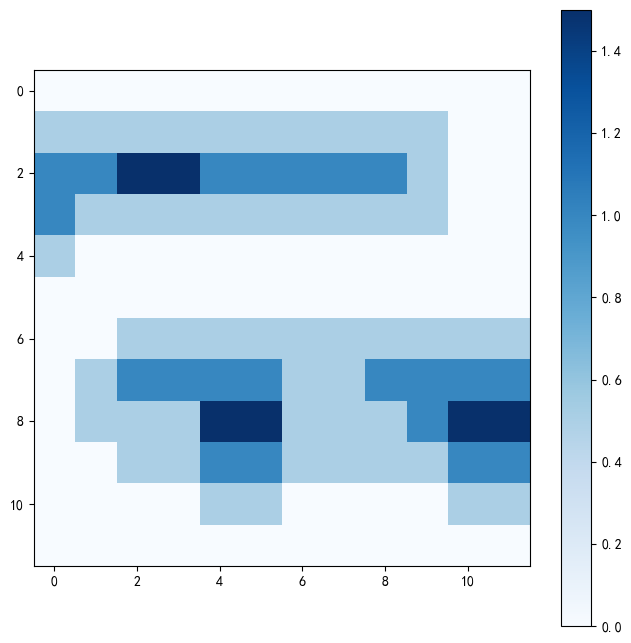

In [143]:
plot_set(map_type)

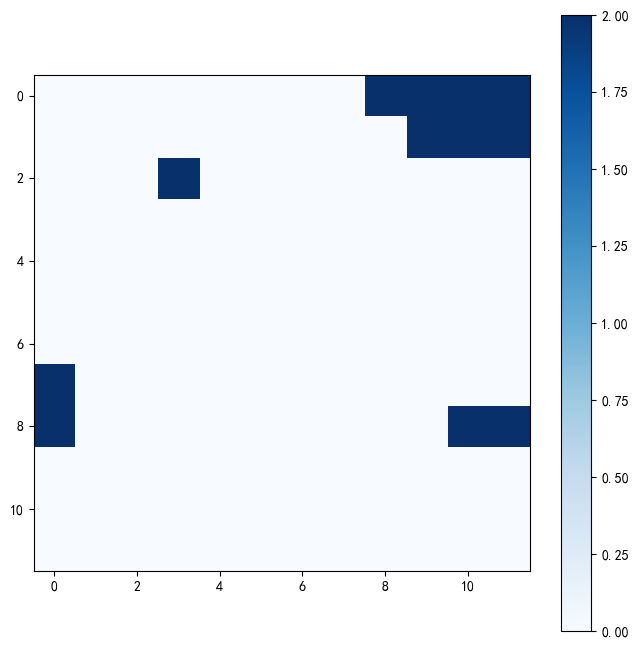

In [144]:
plot_state_set(S_list[N])

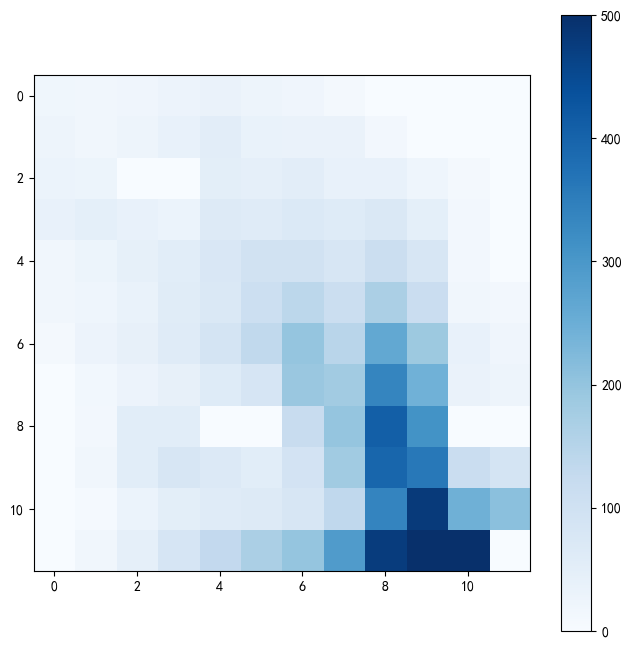

In [147]:

final_state_visit=np.copy(state_visit[N])
final_state_visit[nrow-1,ncol-1]=0
plot_set(np.minimum(final_state_visit,500))

In [148]:
total_data_number=0
for i in range(len(data_list)):
    total_data_number+=len(data_list[i])
total_data_number

77173

In [150]:
total_violation

6

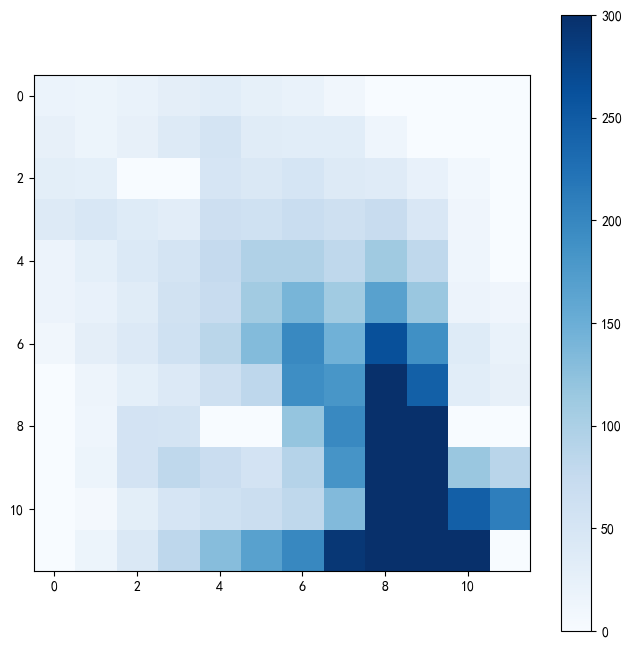

In [ ]:
state_attemp=np.minimum(300*np.ones((nrow,ncol)),final_state_visit)
plot_set(state_attemp)

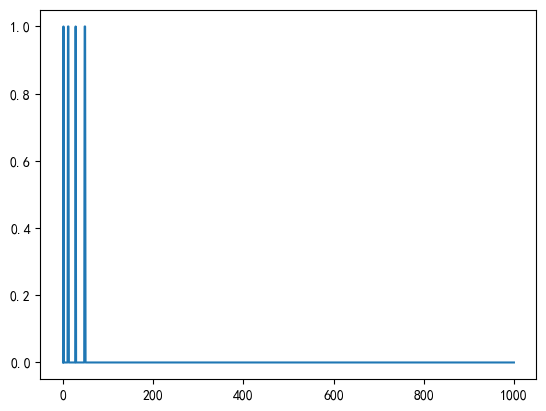

In [ ]:
count_hole_list=np.zeros(N+1)
for i in range(i+1):
    count_hole_list[i]=count_route_holes(data_list[i])
count_hole_list
plt.plot(np.linspace(0,N,N+1),count_hole_list)

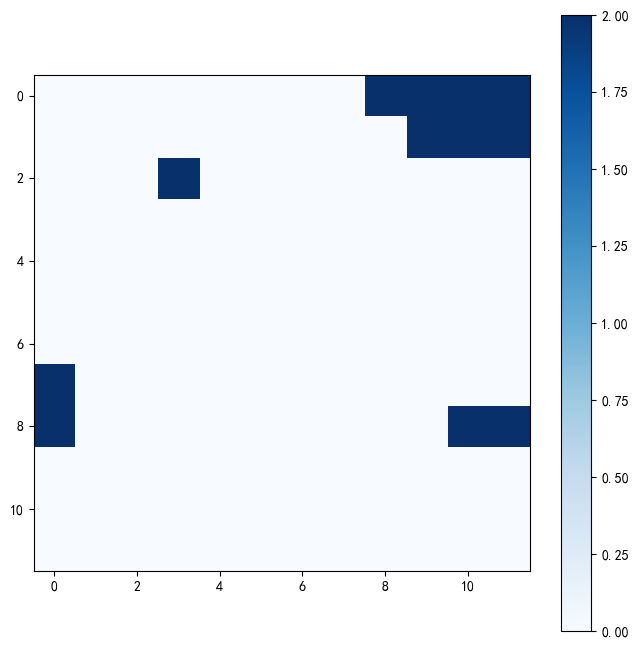

In [ ]:
plot_state_set(S_list[N])

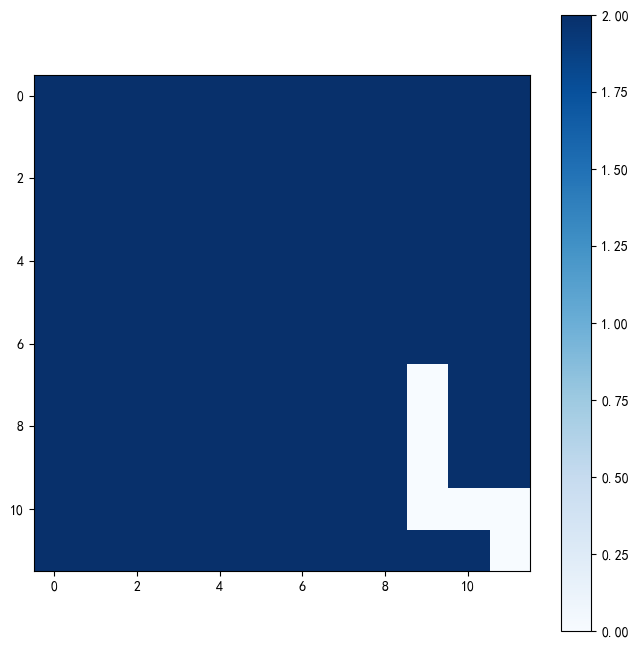

In [ ]:
plot_route(data_list[N])

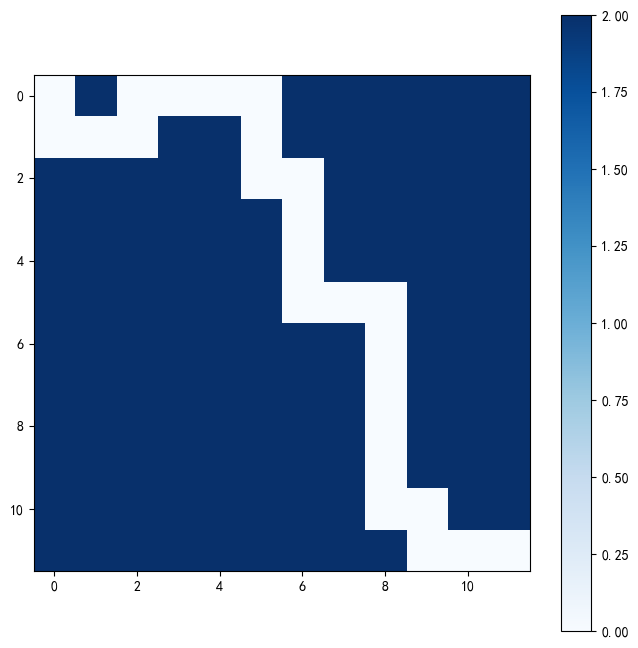

In [ ]:
plot_route(final_route(rtilde,pi))

In [ ]:
total_visit

77174

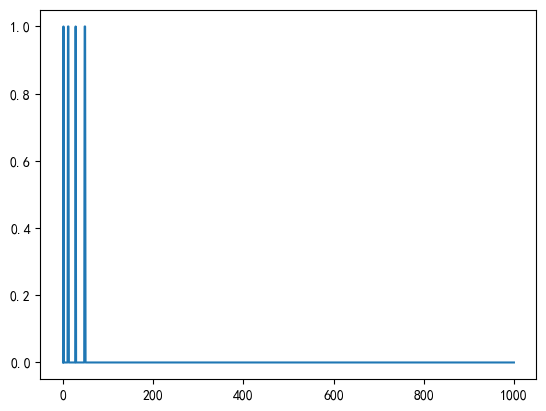

In [ ]:
count_hole_list=np.zeros(N+1)
for i in range(N+1):
    count_hole_list[i]=count_route_holes(data_list[i])
count_hole_list
plt.plot(np.linspace(0,N,N+1),count_hole_list)